# T1 and T2 relaxation analysis
Produces figure 5 in the paper and the table value of T1 and T2 in the different phantom features (found in the supplementary material).

In [7]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ghost.phantom import Caliber137

In [2]:
all_df = pd.read_csv('../data/relaxometry_results_240816.csv', index_col=None)
all_df['Session'] = all_df['Session'].astype(str)

In [3]:
def make_linear_fit(x,y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    pred_ols = results.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    cfi = results.conf_int().loc['x1'].values
    r = results.params.x1

    return r, results, cfi, iv_l, iv_u

def filter_df(df, sub, ses, seg, quant):
    return df.query("Session==@ses & Subject==@sub & Segmentation==@seg & Quant==@quant")

def make_relax_plot(sub, x, y, ax, x_label, y_label):
    r, results, cfi, iv_l, iv_u = make_linear_fit(x,y)
    l = ax.plot(x, y, 'o')
    color = l[0].get_color()
    l = ax.plot(x, results.fittedvalues, '--', color=color, label=rf'({sub}) $r_{1}={r:.3} \pm {results.bse.x1:.1}$')
    ax.fill_between(x, iv_u, iv_l, alpha=0.2, color=color)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.axis([0,None,0,None])
    return r, results, l


In [4]:
sub = 'P0004'
ses = '230224'

# NiCl2 - "T1 mimics"
dfT1 = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_nicl = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]'])
df_nicl['Mimic'] = [f'T1 {i}' for i in range(1,15)]
df_nicl['Content'] = 'NiCl2'
df_nicl['Conc. [mM]'] = dfT1['Concentration']
df_nicl['T1 [s]'] = dfT1['Median']
df_nicl['T2 [s]'] = dfT2['Median']

# MnCl2 - "T2 mimics"
dfT1 = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_mncl = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]'])
df_mncl['Mimic'] = [f'T2 {i}' for i in range(1,15)]
df_mncl['Content'] = 'MnCl2'
df_mncl['Conc. [mM]'] = dfT1['Concentration']
df_mncl['T1 [s]'] = dfT1['Median']
df_mncl['T2 [s]'] = dfT2['Median']

# PVP - "ACD mimics"
dfT1 = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T1').reset_index(drop=True).sort_values(by='LabelValue')
dfT2 = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T2').reset_index(drop=True).sort_values(by='LabelValue')

df_adc = pd.DataFrame(columns=['Mimic', 'Content', 'Conc. [mM]', 'T1 [s]', 'T2 [s]', 'ADC'])
df_adc['Mimic'] = [f'ADC {i}' for i in range(1,15)]
df_adc['Content'] = 'PVP'
df_adc['Conc. [mM]'] = dfT1['Concentration']
df_adc['T1 [s]'] = dfT1['Median']
df_adc['T2 [s]'] = dfT2['Median']
df_adc['ADC'] = dfT1['ADC']

pvp_adc = {0.0:2393, 10.0:1884, 20.0:1439, 30.0:1047, 40.0:654, 50.0:388}

df_adc.rename(columns={'ADC': r'ADC (um2/s)'}, inplace=True)

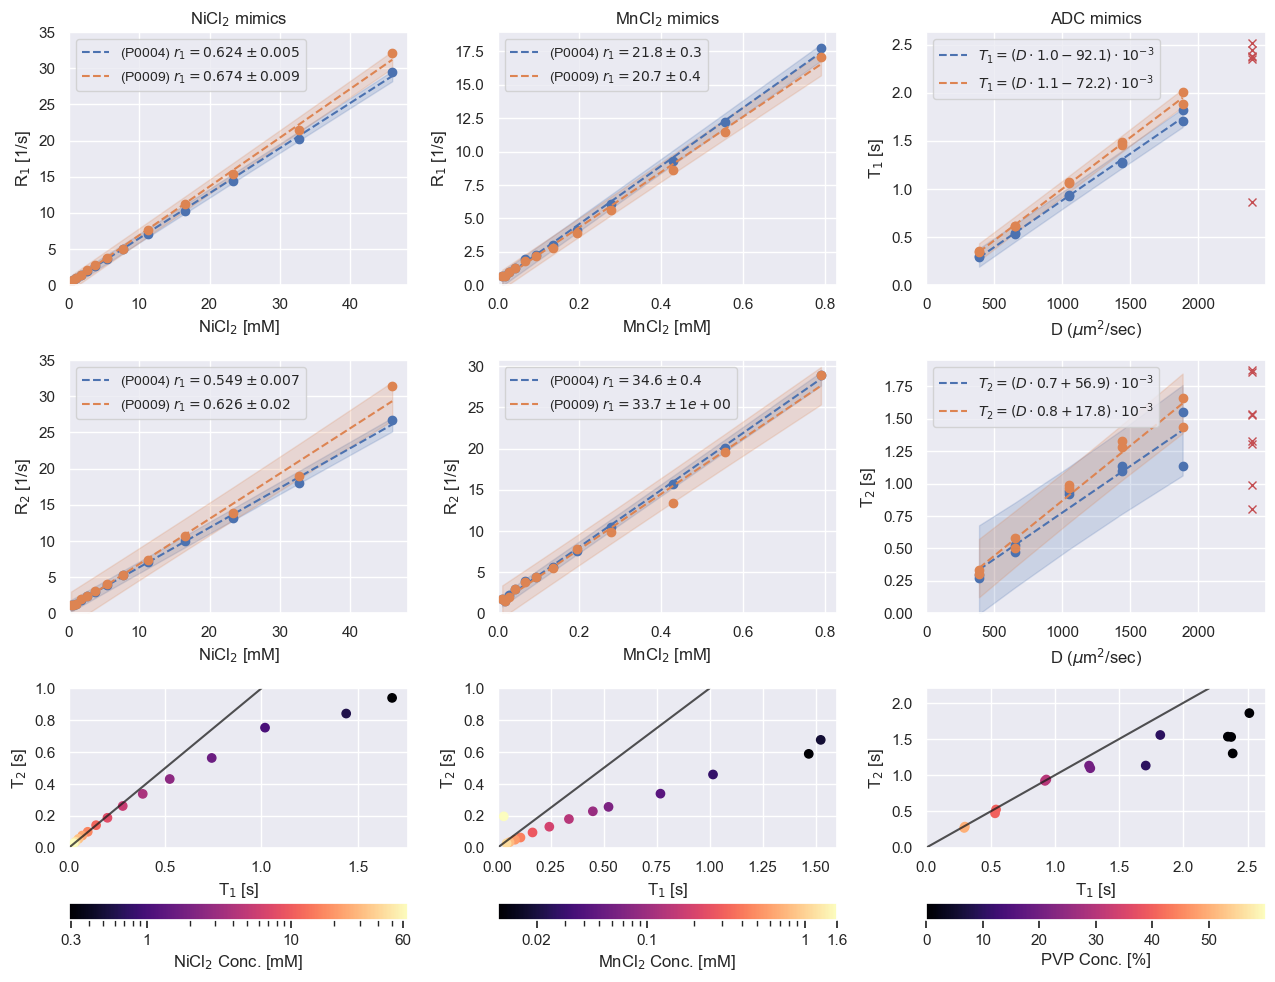

In [12]:
NiCl_thr = 60
MnCl_thr = 1

sns.set_theme()

fig, axes = plt.subplots(3,3, figsize=(13,10))

subjects = ['P0004', 'P0009']
sessions = ['230224', '20240708']

for sub,ses in zip(subjects, sessions):

    ### R1 T1 mimics ###
    df = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='R1').query('Concentration<@NiCl_thr')

    make_relax_plot(sub, x=np.array(df['Concentration']), y=df['Median'], 
                    ax=axes[0,0], y_label=r'R$_1$ [1/s]', x_label=r'NiCl$_2$ [mM]')
    
    ### R1 T2 mimics ###
    df = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='R1').query('Concentration<@MnCl_thr')
    
    make_relax_plot(sub, x=np.array(df['Concentration']), y=df['Median'], 
                    ax=axes[0,1], y_label=r'R$_1$ [1/s]', x_label=r'MnCl$_2$ [mM]')


    ### T1 ADC mimics ###
    df = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T1').sort_values(by='ADC')
    
    df_filt = df.query('ADC<2000')
    df_0 = df.query('ADC>2000')
    l = axes[0,2].plot(df_0['ADC'], df_0['Median'], 'xr')
    r, results, l = make_relax_plot(sub, x=np.array(df_filt['ADC']), y=df_filt['Median'], 
                                    ax=axes[0,2], x_label=r'D ($\mu$m$^2$/sec)', y_label=r'T$_1$ [s]')
    l[0].set_label(fr'$T_1=(D\cdot{results.params.x1*1E3:.1f}{results.params.const*1E3:.1f})\cdot 10^{{-3}}$')


    ### R2 T1 mimics ###
    df = filter_df(all_df, sub, ses, seg='T1mimics_fix', quant='R2').query('Concentration < @NiCl_thr')
    
    make_relax_plot(sub, x=np.array(df['Concentration']), y=df['Median'], 
                    ax=axes[1,0], x_label=r'NiCl$_2$ [mM]', y_label=r'R$_2$ [1/s]')
    
    ### R2 T2 mimics ###
    df = filter_df(all_df, sub, ses, seg='T2mimics_fix', quant='R2').query('Concentration < @MnCl_thr')
    
    make_relax_plot(sub, x=np.array(df['Concentration']), y=df['Median'], ax=axes[1,1], x_label=r'MnCl$_2$ [mM]', y_label=r'R$_2$ [1/s]')
    

    ### T2 ADC mimics ###
    df = filter_df(all_df, sub, ses, seg='ADC_fix', quant='T2').sort_values(by='ADC')
    
    df_filt = df.query('ADC<2000')
    df_0 = df.query('ADC>2000')
    
    axes[1,2].plot(df_0['ADC'], df_0['Median'], 'xr')
    r, results, l = make_relax_plot(sub, x=np.array(df_filt['ADC']), y=df_filt['Median'], 
                                    ax=axes[1,2], x_label=r'D ($\mu$m$^2$/sec)', y_label=r'T$_2$ [s]')
    l[0].set_label(fr'$T_2=(D\cdot{results.params.x1*1E3:.1f}+{results.params.const*1E3:.1f})\cdot 10^{{-3}}$')
    

labels = ['A','B','C','D','E','F']
for i,ax in enumerate(axes.flatten()[0:-3]):
    ax.legend(fontsize=10, loc='upper left')

axes[0,0].set_title(r'NiCl$_2$ mimics')
axes[0,1].set_title(r'MnCl$_2$ mimics')
axes[0,2].set_title('ADC mimics')

cmap = plt.get_cmap('magma')

#### T1 ####
norm = mcolors.LogNorm(vmin=df_nicl['Conc. [mM]'].min(), vmax=df_nicl['Conc. [mM]'].max())
sc = axes[2,0].scatter(df_nicl['T1 [s]'], df_nicl['T2 [s]'], c=df_nicl['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,0].plot([0,1], [0,1], '-k', zorder=1, alpha=0.75)
axes[2,0].set_xlabel(r'T$_1$ [s]')
axes[2,0].set_ylabel(r'T$_2$ [s]')

cb = plt.colorbar(sc, ax=axes[2,0], label=r'NiCl$_2$ Conc. [mM]', orientation='horizontal', pad=.22)
ticks = [0.3, 1, 10, 60]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

#### T2 ####
norm = mcolors.LogNorm(vmin=df_mncl['Conc. [mM]'].min(), vmax=df_mncl['Conc. [mM]'].max())
sc = axes[2,1].scatter(df_mncl['T1 [s]'], df_mncl['T2 [s]'], c=df_mncl['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,1].plot([0,1], [0,1], '-k', zorder=1, alpha=0.75)
axes[2,1].set_xlabel(r'T$_1$ [s]')
axes[2,1].set_ylabel(r'T$_2$ [s]')

cb = plt.colorbar(sc, ax=axes[2,1], label=r'MnCl$_2$ Conc. [mM]', orientation='horizontal', pad=.22)
ticks = [0.02, .1, 1, 1.6]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

#### ADC ####
norm = mcolors.Normalize(vmin=df_adc['Conc. [mM]'].min(), vmax=60)
sc = axes[2,2].scatter(df_adc['T1 [s]'], df_adc['T2 [s]'], c=df_adc['Conc. [mM]'], cmap=cmap, norm=norm)
axes[2,2].plot([0,2.2], [0,2.2], '-k', zorder=1, alpha=0.75)
axes[2,2].set_xlabel(r'T$_1$ [s]')
axes[2,2].set_ylabel(r'T$_2$ [s]')

cb = plt.colorbar(sc, ax=axes[2,2], label='PVP Conc. [%]', orientation='horizontal', pad=.22)
ticks = [0,10,20,30,40,50]
cb.set_ticks(ticks)
cb.set_ticklabels([f"{x}" for x in ticks])

# Fix axes
axes[0,0].axis([0, None, 0, 35])
axes[1,0].axis([0, None, 0, 35])
axes[2,0].axis([0, None,0,1])
axes[2,1].axis([0, None,0,1])
axes[2,2].axis([0, None,0,2.2])

plt.tight_layout()
plt.savefig('../results/figure5_relaxometry.png')
plt.show()

In [13]:
df_adc.to_csv('../results/relaxometry_PVP_mimics.csv')
df_mncl.to_csv('../results/relaxometry_MnCl_mimics.csv')
df_nicl.to_csv('../results/relaxometry_NiCl_mimics.csv')

## Comparison to high field

In [20]:
# Ref values obtained from NIST measurements at 3T @ 20 C
NiCl2_conc = [0.29, 0.6, 1.04, 1.64, 2.52, 3.68, 5.43, 7.74, 11.3, 16.5, 23.3, 32.7, 46, 65.3]
NiCl2_T1 = np.array([1884, 1330.2, 987.3, 690.1, 485, 341.6, 240.9, 174.9, 121.1, 85.8, 60.2, 42.9, 30.4, 21.4])*1E-3
NiCl2_T2 = np.array([1489.4,1026.8,737,521.3,354.4,248,175,126.3,86.9,60.9,42.4,30.7,21.8,15.3])*1E-3

MnCl2_conc = [0.011,0.018,0.028,0.043,0.067,0.093,0.135,0.193,0.277,0.428,0.555,0.79,1.127,1.6]
MnCl2_T1 = np.array([2478.2,2185.5,1901.3,1550,1197.6,1026.4,805.1,600,431.2,292.9,226.5,158.2,116.7,82.5])*1E-3
MnCl2_T2 = np.array([552.7,379.5,267.3,175.1,112.7,88.9,63.4,44.2,29.9,19.4,14.7,10.5,7.3,5.1])*1E-3

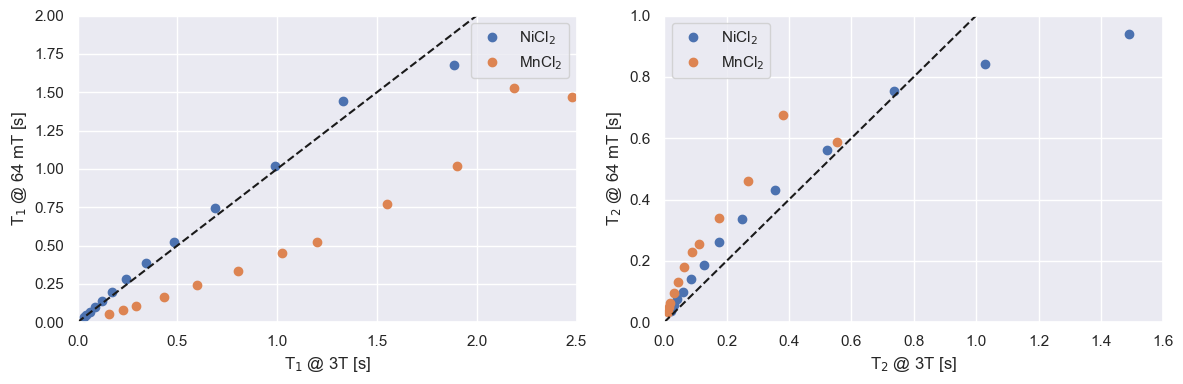

In [41]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]

ax.plot(NiCl2_T1[:-1], df_nicl['T1 [s]'][:-1], 'o', label=r'NiCl$_2$')
ax.plot(MnCl2_T1[:-2], df_mncl['T1 [s]'][:-2], 'o', label=r'MnCl$_2$')
ax.plot([0,2],[0,2], '--k')
ax.set_xlabel('T$_1$ @ 3T [s]')
ax.set_ylabel('T$_1$ @ 64 mT [s]')
ax.axis([0,2.5,0,2])
ax.legend()

ax = axes[1]

ax.plot(NiCl2_T2[:-1], df_nicl['T2 [s]'][:-1], 'o', label=r'NiCl$_2$')
ax.plot(MnCl2_T2[:-2], df_mncl['T2 [s]'][:-2], 'o', label=r'MnCl$_2$')
ax.plot([0,2],[0,2], '--k')
ax.set_xlabel('T$_2$ @ 3T [s]')
ax.set_ylabel(r'T$_2$ @ 64 mT [s]')
ax.axis([0,1.6,0,1])
ax.legend()

plt.tight_layout()
plt.savefig('../results/figureS6_relax_compare_64mT_3T.png', dpi=300)
plt.show()